# <center>Unsupervised learning: PCA and clustering

  
In this lesson, we will work with unsupervised learning methods such as Principal Component Analysis (PCA) and clustering. You will learn why and how we can reduce the dimensionality of the original data and what the main approaches are for grouping similar data points.  


## 1. Introduction

The main feature of unsupervised learning algorithms, when compared to classification and regression methods, is that input data are unlabeled (i.e. no labels or classes given) and that the algorithm learns the structure of the data without any assistance. This creates two main differences. First, it allows us to process large amounts of data because the data does not need to be manually labeled. Second, it is difficult to evaluate the quality of an unsupervised algorithm due to the absence of an explicit goodness metric as used in supervised learning.  

One of the most common tasks in unsupervised learning is dimensionality reduction. On one hand, dimensionality reduction may help with data visualization (e.g. t-SNA method) while, on the other hand, it may help deal with the multicollinearity of your data and prepare the data for a supervised learning method (e.g. decision trees).


## 2. Principal Component Analysis (PCA)

Principal Component Analysis is one of the easiest, most intuitive, and most frequently used methods for dimensionality reduction, projecting data onto its orthogonal feature subspace.


<img align="right" src="https://habrastorage.org/getpro/habr/post_images/bb6/fe7/f06/bb6fe7f06e114bcc9c354a1cb025b966.png" width="400">

## Examples
### Fisher's iris dataset

Let's start by uploading all of the essential modules and try out the iris example we used in project 1 from the `scikit-learn` documentation. 

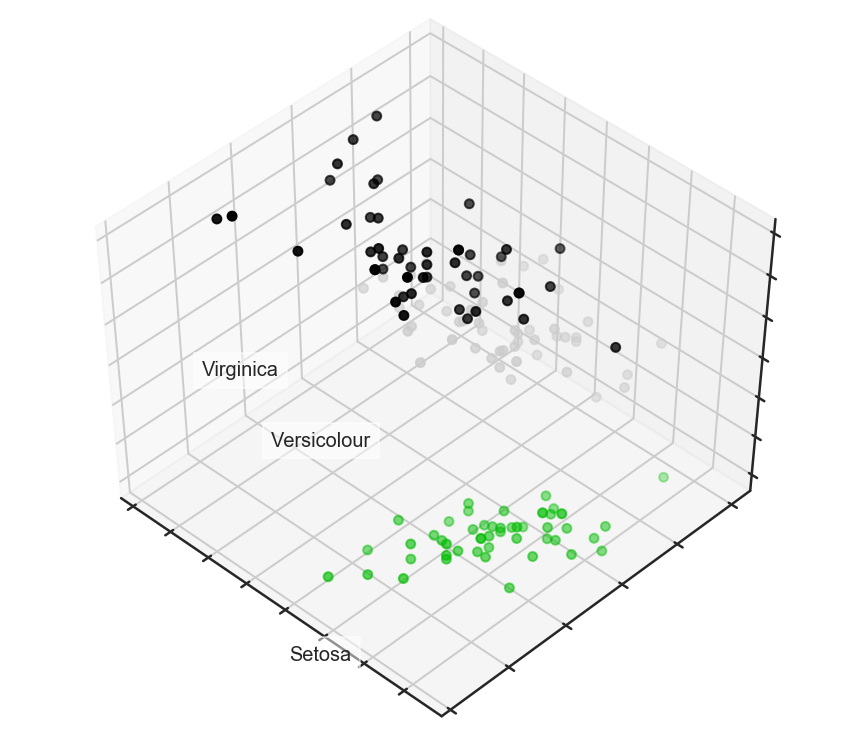

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(style='white')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from sklearn import decomposition
from sklearn import datasets
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler


# Loading the dataset
iris = datasets.load_iris()
X = iris.data
y = iris.target

# Let's create a beautiful 3d-plot
fig = plt.figure(1, figsize=(6, 5))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

plt.cla()

for name, label in [('Setosa', 0), ('Versicolour', 1), ('Virginica', 2)]:
    ax.text3D(X[y == label, 0].mean(),
              X[y == label, 1].mean() + 1.5,
              X[y == label, 2].mean(), name,
              horizontalalignment='center',
              bbox=dict(alpha=.5, edgecolor='w', facecolor='w'))
# Change the order of labels, so that they match
y_clr = np.choose(y, [1, 2, 0]).astype(np.float)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y_clr, 
           cmap=plt.cm.nipy_spectral)

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([]);

Now let's see how PCA will improve the results of a simple model that is not able to correctly fit all of the training data:

In [29]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

# Train, test splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, 
                                                    stratify=y, 
                                                    random_state=42)

# Decision trees with depth = 2
clf = DecisionTreeClassifier(max_depth=2, random_state=42)
clf.fit(X_train, y_train)
preds = clf.predict_proba(X_test)
print('Accuracy: {:.5f}'.format(accuracy_score(y_test, 
                                                preds.argmax(axis=1))))

Accuracy: 0.88889


Let's try this again, but, this time, let's reduce the dimensionality to 2 dimensions:

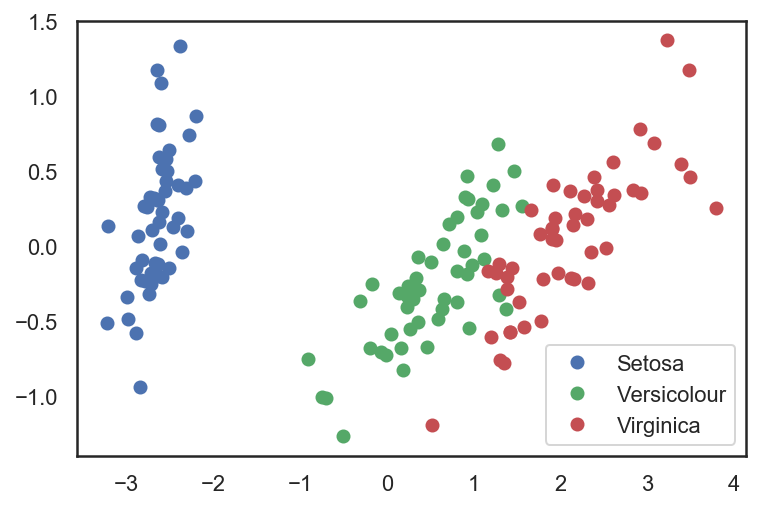

In [30]:
# Using PCA from sklearn PCA
pca = decomposition.PCA(n_components=2)
X_centered = X - X.mean(axis=0)
pca.fit(X_centered)
X_pca = pca.transform(X_centered)

# Plotting the results of PCA
plt.plot(X_pca[y == 0, 0], X_pca[y == 0, 1], 'bo', label='Setosa')
plt.plot(X_pca[y == 1, 0], X_pca[y == 1, 1], 'go', label='Versicolour')
plt.plot(X_pca[y == 2, 0], X_pca[y == 2, 1], 'ro', label='Virginica')
plt.legend(loc=0);

In [31]:
# Test-train split and apply PCA
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=.3, 
                                                    stratify=y, 
                                                    random_state=42)

clf = DecisionTreeClassifier(max_depth=2, random_state=42)
clf.fit(X_train, y_train)
preds = clf.predict_proba(X_test)
print('Accuracy: {:.5f}'.format(accuracy_score(y_test, 
                                                preds.argmax(axis=1))))

Accuracy: 0.91111


The accuracy did not increase significantly in this case, but, with other datasets with a high number of dimensions, PCA can drastically improve the accuracy of decision trees and other ensemble methods.

Now let's check out the percent of variance that can be explained by each of the selected components.

In [5]:
for i, component in enumerate(pca.components_):
    print("{} component: {}% of initial variance".format(i + 1, 
          round(100 * pca.explained_variance_ratio_[i], 2)))
    print(" + ".join("%.3f x %s" % (value, name)
                     for value, name in zip(component,
                                            iris.feature_names)))

1 component: 92.46% of initial variance
0.361 x sepal length (cm) + -0.085 x sepal width (cm) + 0.857 x petal length (cm) + 0.358 x petal width (cm)
2 component: 5.31% of initial variance
0.657 x sepal length (cm) + 0.730 x sepal width (cm) + -0.173 x petal length (cm) + -0.075 x petal width (cm)


### Handwritten numbers dataset 

Let's look at the handwritten numbers dataset(https://habrahabr.ru/company/ods/blog/322534/#derevya-resheniy-i-metod-blizhayshih-sosedey-v-zadache-raspoznavaniya-rukopisnyh-cifr-mnist).

In [6]:
digits = datasets.load_digits()
X = digits.data
y = digits.target

In [7]:
print (f"Number of classes are {set(y)}")

Number of classes are {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}


Let's start by visualizing our data. Fetch the first 10 numbers. The numbers are represented by 8 x 8 matrixes with the color intensity for each pixel. Every matrix is flattened into a vector of 64 numbers, so we get the feature version of the data.

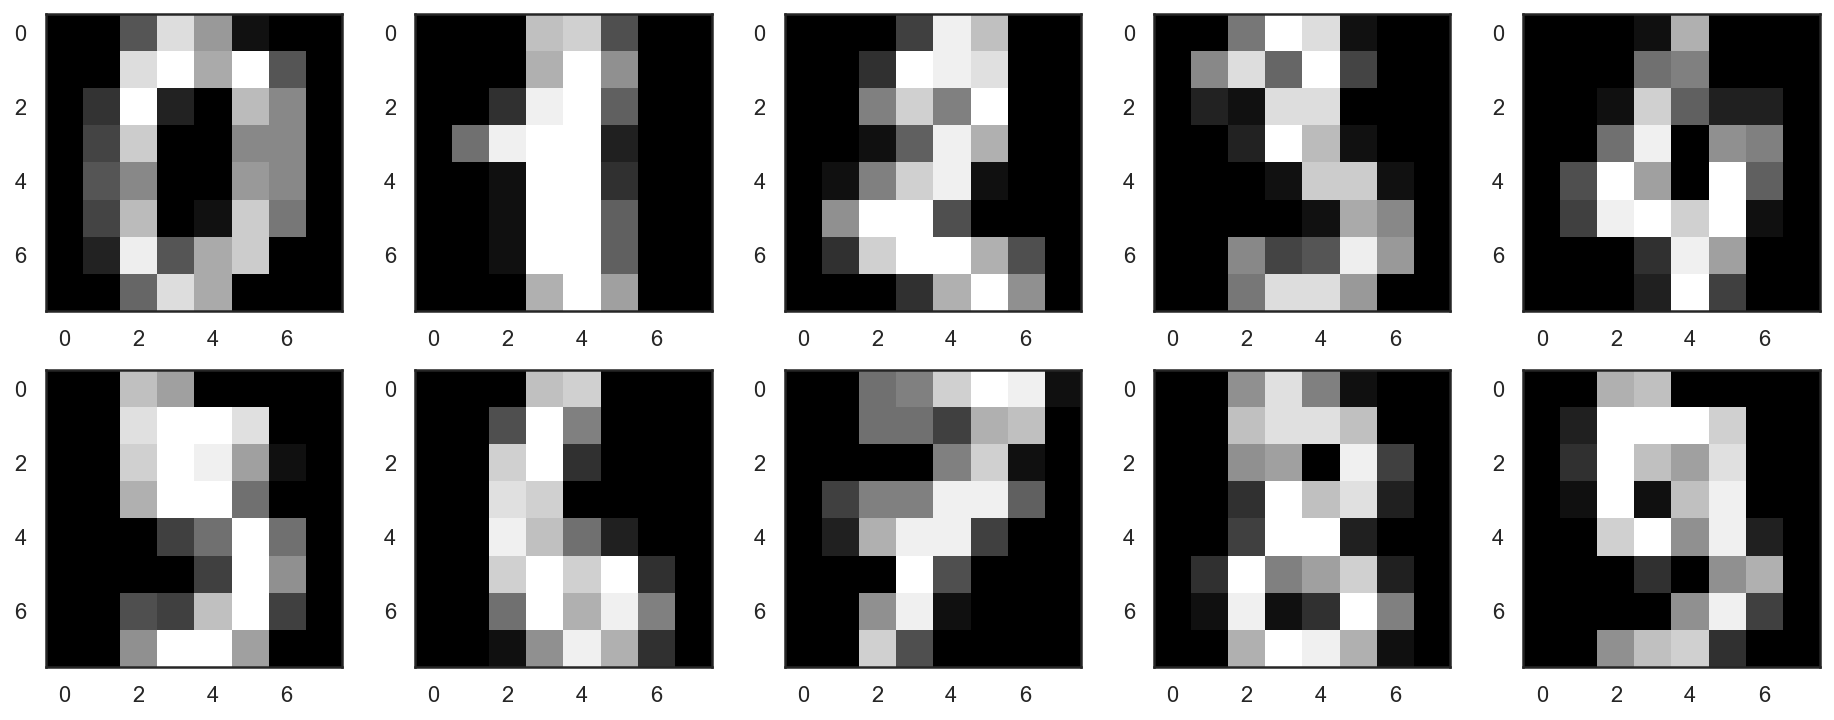

In [8]:
# f, axes = plt.subplots(5, 2, sharey=True, figsize=(16,6))
plt.figure(figsize=(16, 6))
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X[i,:].reshape([8,8]), cmap='gray');

Our data has 64 dimensions, but we are going to reduce it to only 2 and see that, even with just 2 dimensions, we can clearly see that digits separate into clusters.

Projecting 64-dimensional data to 2D


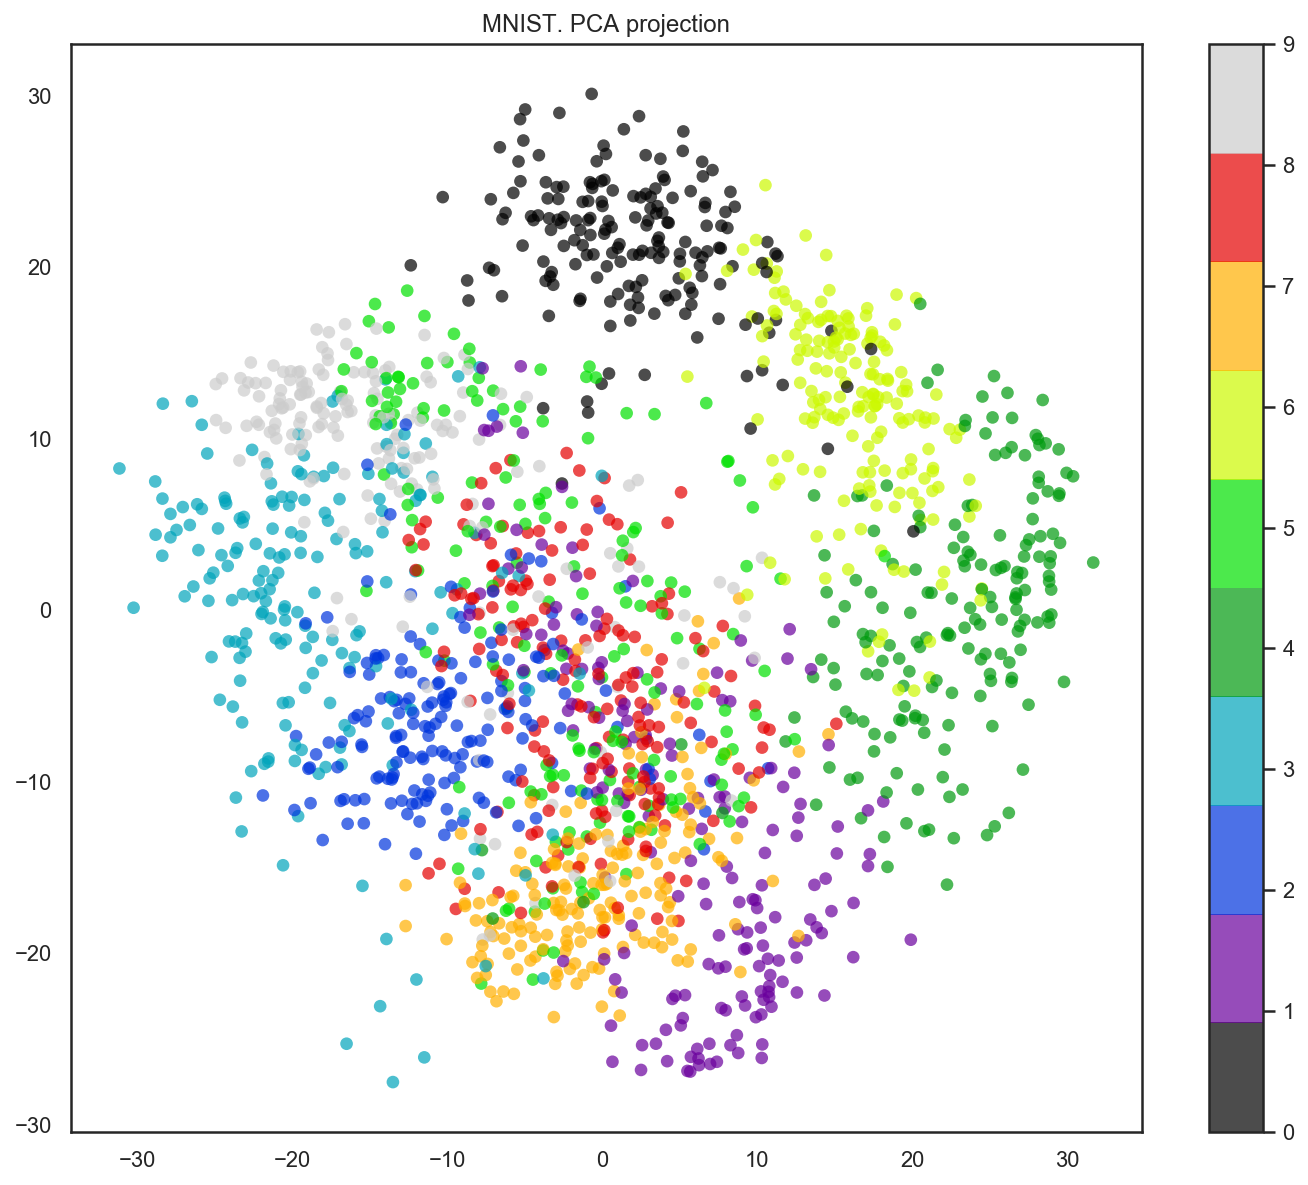

In [9]:
pca = decomposition.PCA(n_components=2)
X_reduced = pca.fit_transform(X)

print('Projecting %d-dimensional data to 2D' % X.shape[1])

plt.figure(figsize=(12,10))
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, 
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.title('MNIST. PCA projection');

Indeed, with t-SNE, the picture looks better since PCA has a linear constraint while t-SNE does not. However, even with such a small dataset, the t-SNE algorithm takes significantly more time to complete than PCA.

Wall time: 5.98 s


Text(0.5, 1.0, 'MNIST. t-SNE projection')

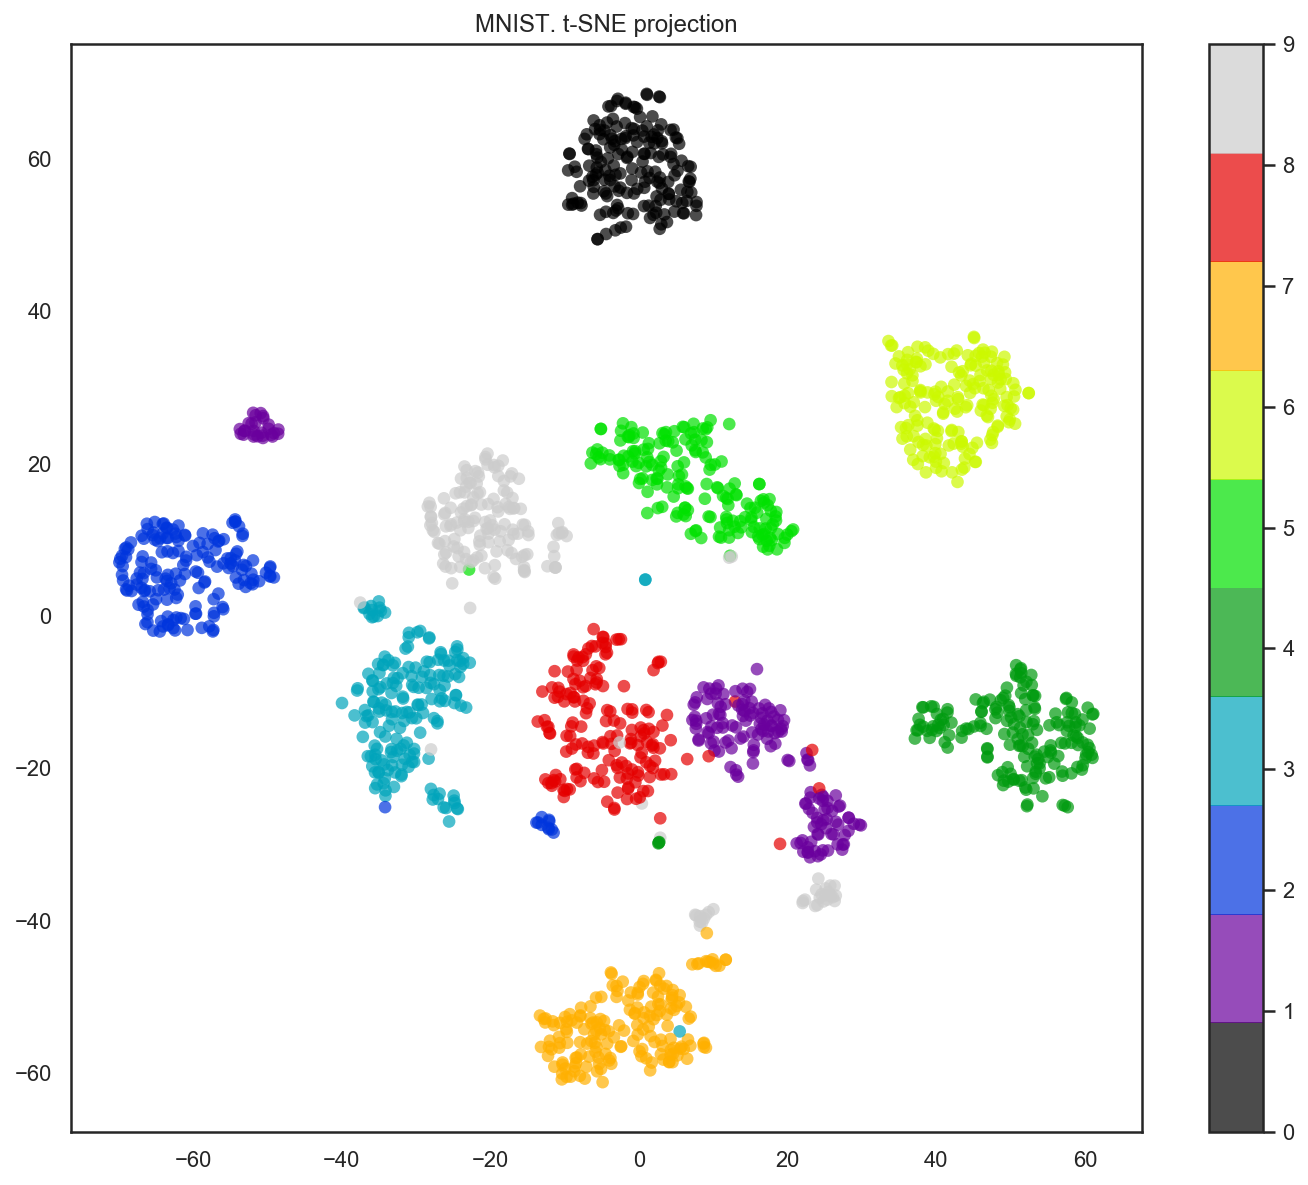

In [10]:
%%time

from sklearn.manifold import TSNE
tsne = TSNE(random_state=17)

X_tsne = tsne.fit_transform(X)

plt.figure(figsize=(12,10))
plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y, 
            edgecolor='none', alpha=0.7, s=40,
            cmap=plt.cm.get_cmap('nipy_spectral', 10))
plt.colorbar()
plt.title('MNIST. t-SNE projection');

In practice, we would choose the number of principal components such that we can explain 90% of the initial data dispersion (via the `explained_variance_ratio`). Here, that means retaining 21 principal components; therefore, we reduce the dimensionality from 64 features to 21.

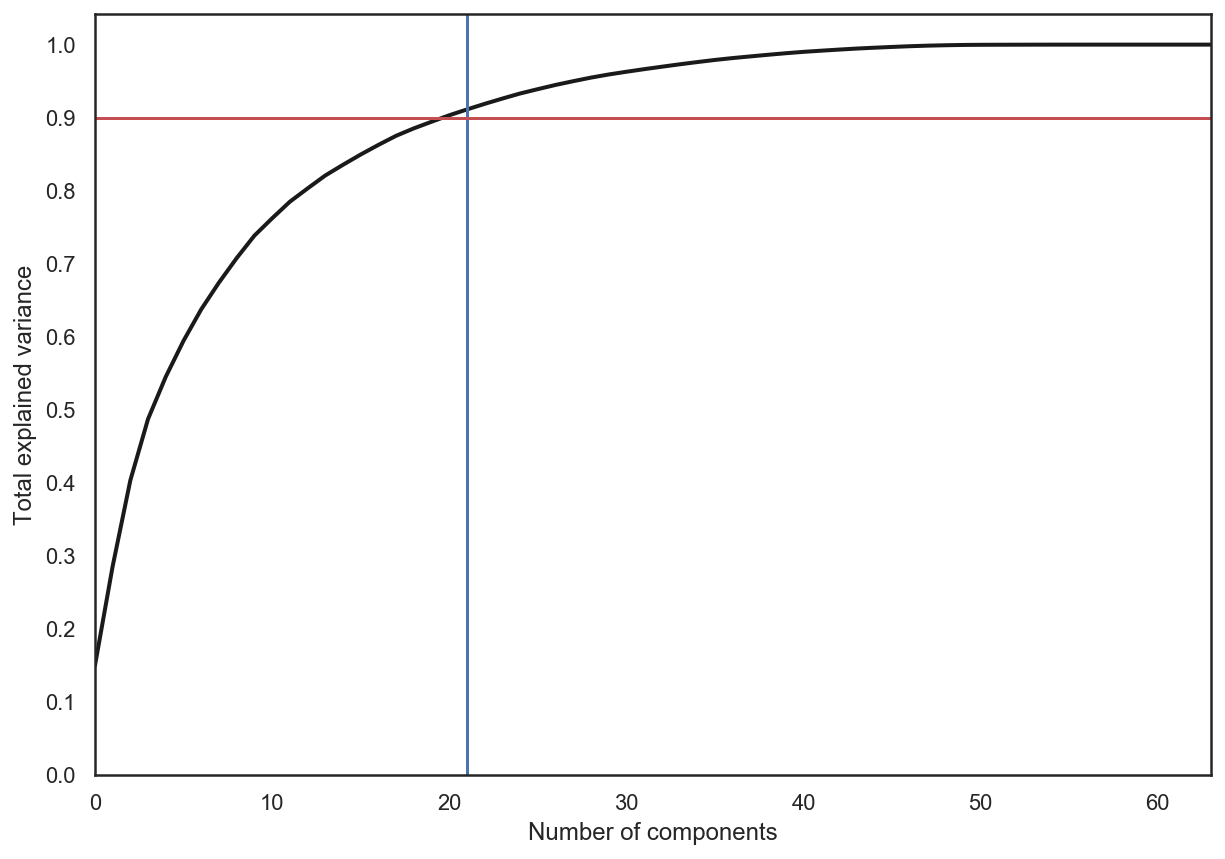

In [11]:
pca = decomposition.PCA().fit(X)

plt.figure(figsize=(10,7))
plt.plot(np.cumsum(pca.explained_variance_ratio_), color='k', lw=2)
plt.xlabel('Number of components')
plt.ylabel('Total explained variance')
plt.xlim(0, 63)
plt.yticks(np.arange(0, 1.1, 0.1))
plt.axvline(21, c='b')
plt.axhline(0.9, c='r')
plt.show();

## 2. Clustering

The main idea behind clustering is pretty straightforward. Basically, we say to ourselves, "I have these points here, and I can see that they organize into groups. It would be nice to describe these things more concretely, and, when a new point comes in, assign it to the correct group." This general idea encourages exploration and opens up a variety of algorithms for clustering.

<figure><img align="center" src="https://habrastorage.org/getpro/habr/post_images/8b9/ae5/586/8b9ae55861f22a2809e8b3a00ef815ad.png"><figcaption>*The examples of the outcomes from different algorithms from scikit-learn*</figcaption></figure>

The algorithms listed below do not cover all the clustering methods out there, but they are the most commonly used ones.

### K-means

K-means algorithm is the most popular and yet simplest of all the clustering algorithms. Here is how it works:
1. Select the number of clusters $k$ that you think is the optimal number.
2. Initialize $k$ points as "centroids" randomly within the space of our data.
3. Attribute each observation to its closest centroid.
4. Update the centroids to the center of all the attributed set of observations. 
5. Repeat steps 3 and 4 a fixed number of times or until all of the centroids are stable (i.e. no longer change in step 4).

This algorithm is easy to describe and visualize. Let's take a look.

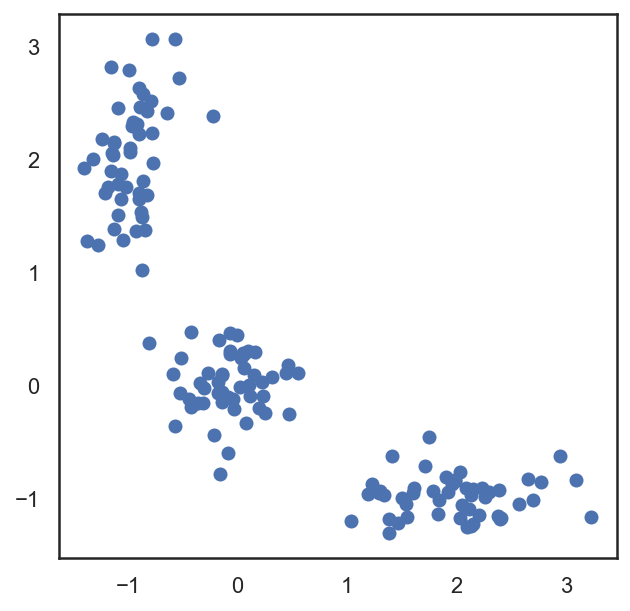

In [12]:
# Let's begin by allocation 3 cluster's points
X = np.zeros((150, 2))

np.random.seed(seed=42)
X[:50, 0] = np.random.normal(loc=0.0, scale=.3, size=50)
X[:50, 1] = np.random.normal(loc=0.0, scale=.3, size=50)

X[50:100, 0] = np.random.normal(loc=2.0, scale=.5, size=50)
X[50:100, 1] = np.random.normal(loc=-1.0, scale=.2, size=50)

X[100:150, 0] = np.random.normal(loc=-1.0, scale=.2, size=50)
X[100:150, 1] = np.random.normal(loc=2.0, scale=.5, size=50)

plt.figure(figsize=(5, 5))
plt.plot(X[:, 0], X[:, 1], 'bo');

In [13]:
# Scipy has function that takes 2 tuples and return
# calculated distance between them
from scipy.spatial.distance import cdist

# Randomly allocate the 3 centroids 
np.random.seed(seed=42)
centroids = np.random.normal(loc=0.0, scale=1., size=6)
centroids = centroids.reshape((3, 2))

cent_history = []
cent_history.append(centroids)

for i in range(3):
    # Calculating the distance from a point to a centroid
    distances = cdist(X, centroids)
    # Checking what's the closest centroid for the point
    labels = distances.argmin(axis=1)
    
    # Labeling the point according the point's distance
    centroids = centroids.copy()
    centroids[0, :] = np.mean(X[labels == 0, :], axis=0)
    centroids[1, :] = np.mean(X[labels == 1, :], axis=0)
    centroids[2, :] = np.mean(X[labels == 2, :], axis=0)
    
    cent_history.append(centroids)

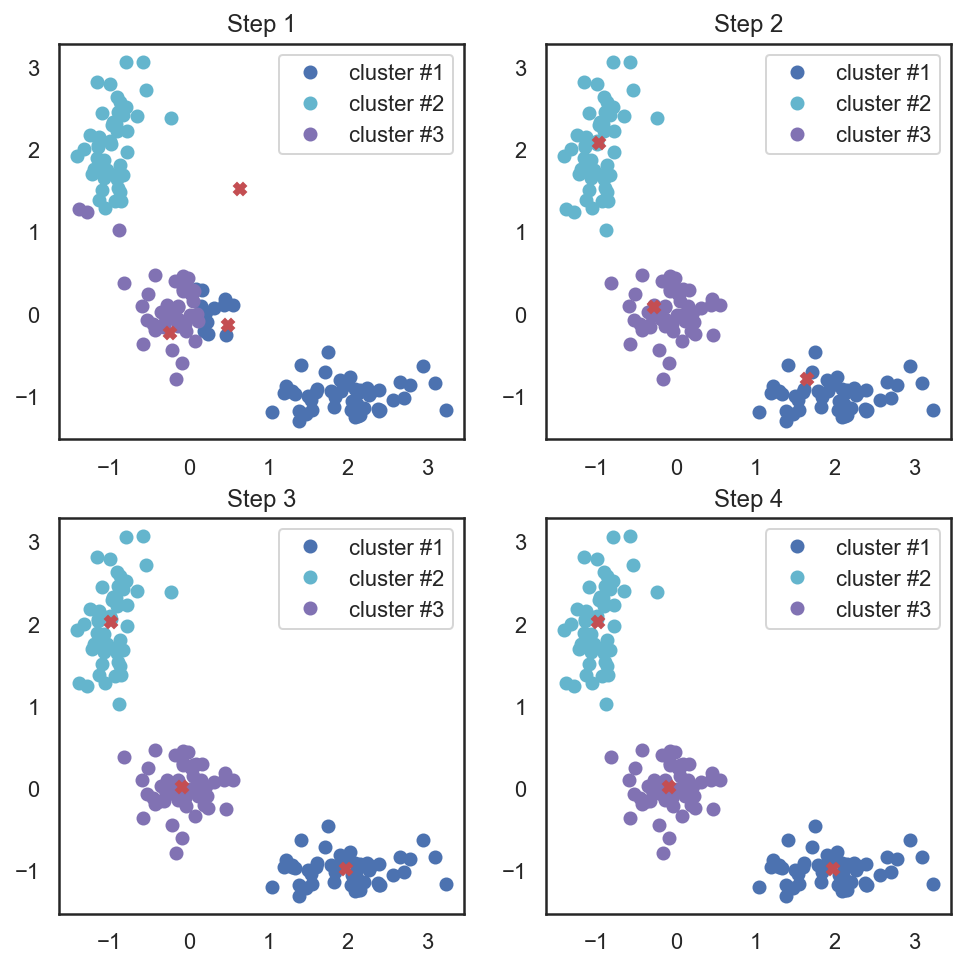

In [14]:
# Let's plot K-means
plt.figure(figsize=(8, 8))
for i in range(4):
    distances = cdist(X, cent_history[i])
    labels = distances.argmin(axis=1)
    
    plt.subplot(2, 2, i + 1)
    plt.plot(X[labels == 0, 0], X[labels == 0, 1], 'bo', label='cluster #1')
    plt.plot(X[labels == 1, 0], X[labels == 1, 1], 'co', label='cluster #2')
    plt.plot(X[labels == 2, 0], X[labels == 2, 1], 'mo', label='cluster #3')
    plt.plot(cent_history[i][:, 0], cent_history[i][:, 1], 'rX')
    plt.legend(loc=0)
    plt.title('Step {:}'.format(i + 1));

Here, we used Euclidean distance, but the algorithm will converge with any other metric. You can not only vary the number of steps or the convergence criteria but also the distance measure between the points and cluster centroids.

Another "feature" of this algorithm is its sensitivity to the initial positions of the cluster centroids. You can run the algorithm several times and then average all the centroid results.

## Choosing the number of clusters for K-means

In contrast to the supervised learning tasks such as classification and regression, clustering requires more effort to choose the optimization criterion. Usually, when working with k-means, we optimize the sum of squared distances between the observations and their centroids.

$$\Large J(C) = \sum_{k=1}^K\sum_{i~\in~C_k} ||x_i - \mu_k|| \rightarrow \min\limits_C,$$

where $C$ – is a set of clusters with power $K$, $\mu_k$ is a centroid of a cluster $C_k$.

This definition seems reasonable -- we want our observations to be as close to their centroids as possible. But, there is a problem -- the optimum is reached when the number of centroids is equal to the number of observations, so you would end up with every single observation as its own separate cluster.

In order to avoid that case, we should choose a number of clusters after which a function $J(C_k)$ is decreasing less rapidly. More formally,
$$\Large D(k) = \frac{|J(C_k) - J(C_{k+1})|}{|J(C_{k-1}) - J(C_k)|}  \rightarrow \min\limits_k $$

Let's look at an example.

In [15]:
from sklearn.cluster import KMeans

In [16]:
inertia = []
for k in range(1, 8):
    kmeans = KMeans(n_clusters=k, random_state=1).fit(X)
    inertia.append(np.sqrt(kmeans.inertia_))


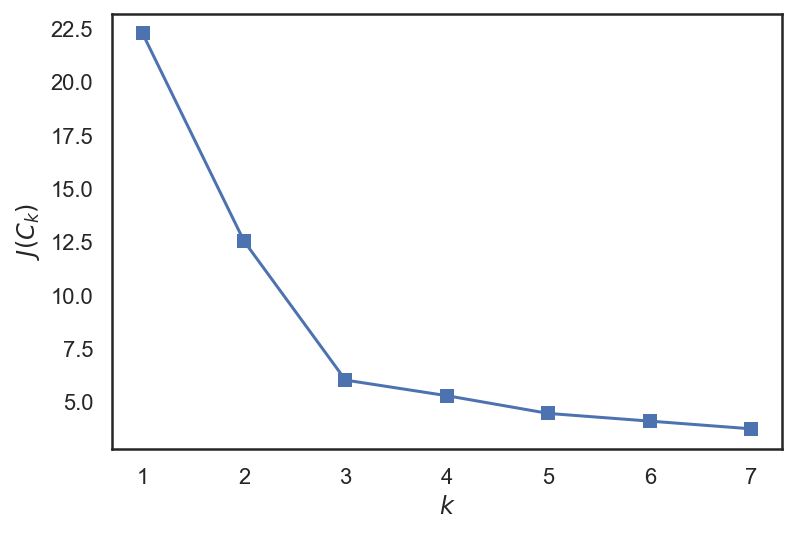

In [17]:
plt.plot(range(1, 8), inertia, marker='s');
plt.xlabel('$k$')
plt.ylabel('$J(C_k)$');

We see that $J(C_k)$ decreases significantly until the number of clusters is 3 and then does not change as much anymore. This means that the optimal number of clusters is 3. 

#### Issues

Inherently, K-means is NP-hard. For $d$ dimensions, $k$ clusters, and $n$ observations, we will find a solution in $O(n^{d k+1})$ in time. There are some heuristics to deal with this; an example is MiniBatch K-means, which takes portions (batches) of data instead of fitting the whole dataset and then moves centroids by taking the average of the previous steps. Compare the implementation of K-means and MiniBatch K-means in the [sckit-learn documentation](http://scikit-learn.org/stable/auto_examples/cluster/plot_mini_batch_kmeans.html).

The [implemetation](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html) of the algorithm using `scikit-learn` has its benefits such as the possibility to state the number of initializations with the `n_init` function parameter, which enables us to identify more robust centroids. Moreover, these runs can be done in parallel to decrease the computation time.

## Spectral clustering

Spectral clustering algorithm requires us to define the similarity matrix for observations called the adjacency matrix. This matrix describes a full graph with the observations as vertices and the estimated similarity value between a pair of observations as edge weights for that pair of vertices. For the metric defined above and two-dimensional observations, this is pretty intuitive - two observations are similar if the edge between them is shorter. 
We'd like to split up the graph into two subgraphs in such a way that each observation in each subgraph would be similar to another observation in that subgraph. Formally, this is a Normalized cuts problem; for more details, we recommend reading [this paper](http://people.eecs.berkeley.edu/~malik/papers/SM-ncut.pdf).

## Agglomerative clustering


The following algorithm is the simplest and easiest to understand among all the the clustering algorithms without a fixed number of clusters.


The algorithm is fairly simple:
1. We start by assigning each observation to its own cluster
2. Then sort the pairwise distances between the centers of clusters in descending order
3. Take the nearest two neigbor clusters and merge them together, and recompute the centers
4. Repeat steps 2 and 3 until all the data is merged into one cluster

The process of searching for the nearest cluster can be conducted with different methods of bounding the observations:
1. Single linkage 
$d(C_i, C_j) = min_{x_i \in C_i, x_j \in C_j} ||x_i - x_j||$
2. Complete linkage 
$d(C_i, C_j) = max_{x_i \in C_i, x_j \in C_j} ||x_i - x_j||$
3. Average linkage 
$d(C_i, C_j) = \frac{1}{n_i n_j} \sum_{x_i \in C_i} \sum_{x_j \in C_j} ||x_i - x_j||$
4. Centroid linkage 
$d(C_i, C_j) = ||\mu_i - \mu_j||$

The 3rd one is the most effective in computation time since it does not require recomputing the distances every time the clusters are merged.

The results can be visualized as a beautiful cluster tree (dendogram) to help recognize the moment the algorithm should be stopped to get optimal results. There are plenty of Python tools to build these dendograms for agglomerative clustering.

Let's consider an example with the clusters we got from K-means:

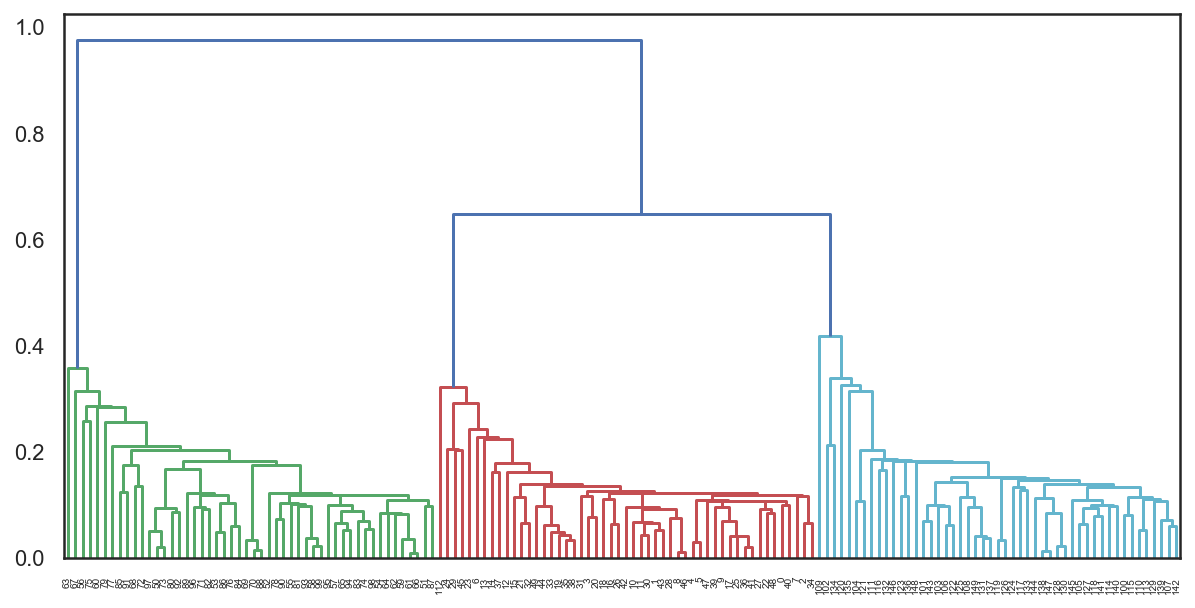

In [18]:
from scipy.cluster import hierarchy
from scipy.spatial.distance import pdist

X = np.zeros((150, 2))

np.random.seed(seed=42)
X[:50, 0] = np.random.normal(loc=0.0, scale=.3, size=50)
X[:50, 1] = np.random.normal(loc=0.0, scale=.3, size=50)

X[50:100, 0] = np.random.normal(loc=2.0, scale=.5, size=50)
X[50:100, 1] = np.random.normal(loc=-1.0, scale=.2, size=50)

X[100:150, 0] = np.random.normal(loc=-1.0, scale=.2, size=50)
X[100:150, 1] = np.random.normal(loc=2.0, scale=.5, size=50)

# pdist will calculate the upper triangle of the pairwise distance matrix
distance_mat = pdist(X) 
# linkage — is an implementation if agglomerative algorithm
Z = hierarchy.linkage(distance_mat, 'single')
plt.figure(figsize=(10, 5))
# <center>Unsupervised learning: PCA and clustering
dn = hierarchy.dendrogram(Z, color_threshold=0.5)

# <center>Samsung Human Activity Recognition

In this task, we will work with the [Samsung Human Activity Recognition] (https://archive.ics.uci.edu/ml/datasets/Human+Activity+Recognition+Using+Smartphones) dataset. The data comes from the accelerometers and gyros of Samsung Galaxy S3 mobile phones ( you can find more info about the features using on the link above), the type of activity of a person with a phone in his pocket is also known - whether he walked, stood, lay, sat or walked up or down the stairs.

We imagine that the type of activity is unknown to us, and we will try to cluster people purely on the basis of available features. 

In [19]:
import os

X_train = np.loadtxt(os.path.join("samsung/", "samsung_train.txt"))
y_train = np.loadtxt(os.path.join("samsung/",
                                  "samsung_train_labels.txt")).astype(int)

X_test = np.loadtxt(os.path.join("samsung/", "samsung_test.txt"))
y_test = np.loadtxt(os.path.join("samsung/",
                                  "samsung_test_labels.txt")).astype(int)

In [20]:
X = np.vstack([X_train, X_test])
y = np.hstack([y_train, y_test])
n_classes = np.unique(y).size
print (f"Number of classes are {n_classes}")

Number of classes are 6


[These labels correspond to:](https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.names)
- 1 - walking
- 2 - going up the stairs
- 3 - going down the stairs
- 4 - sitting
- 5 - standing
- 6 - lying down

[](http://)Scale the sample using `StandardScaler` with default parameters.

In [21]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Reduce the number of dimensions using PCA, leaving as many components as necessary to explain at least 90% of the variance of the original (scaled) data. Use the scaled sample and fix the random_state (RANDOM_STATE constant).

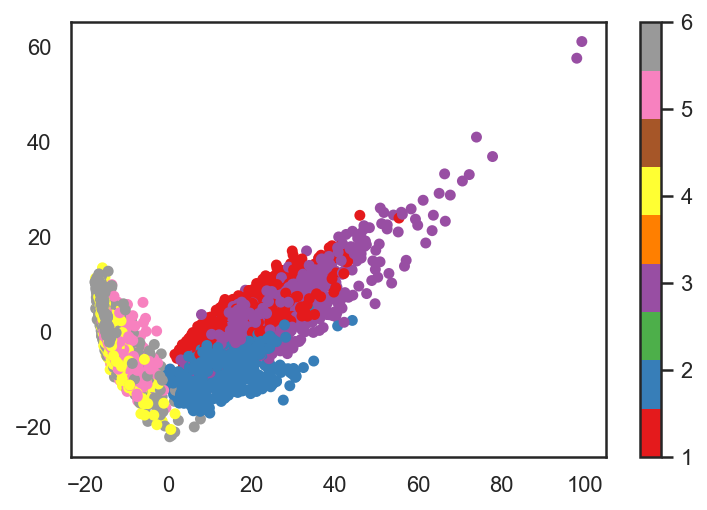

In [22]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.9, random_state=10).fit(X_scaled)
X_pca = pca.transform(X_scaled)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, s=20, cmap='Set1');
plt.colorbar()


Run the data clustering using the KMeans method, training the model on data with a reduced PCA dimension. In this case, we will give a clue to look for exactly 6 clusters, but in general case we will not know how many clusters we should be searching.

Options:

n_clusters = n_classes (number of unique labels of the target class)
n_init = 100
random_state = RANDOM_STATE (for the reproducibility of the result)
Other parameters should have default values.

In [23]:
kmeans = KMeans(n_clusters=n_classes, n_init=100, 
                random_state=10, n_jobs=1)
kmeans.fit(X_pca)
cluster_labels = kmeans.labels_

Visualize the data in the projection on the first two main components. Color the dots according to the clusters received.



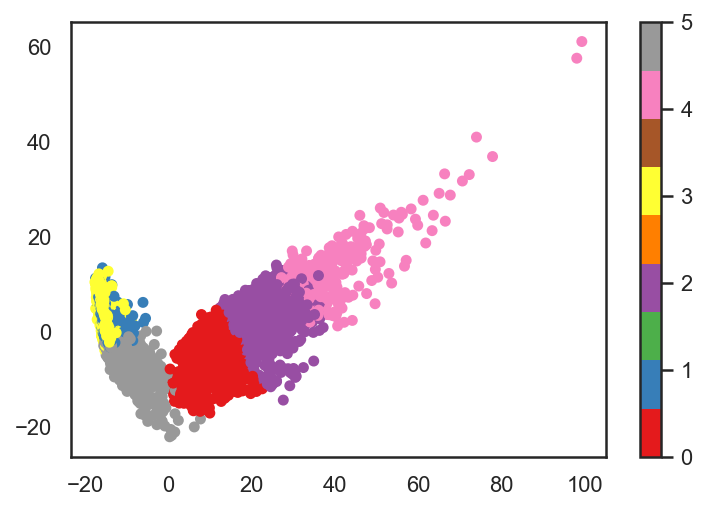

In [24]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, s=20,cmap='Set1');
plt.colorbar()


Look at the correspondence between the cluster marks and the original class labels and what kinds of activities the KMeans algorithm is confused at.



In [25]:
import pandas as pd

tab = pd.crosstab(y, cluster_labels, margins=True)
tab.index = ['walking', 'going up the stairs',
            'going down the stairs', 'sitting', 'standing', 'lying', 'all']
tab.columns = ['cluster' + str(i + 1) for i in range(6)] + ['all']
tab

,cluster1,cluster2,cluster3,cluster4,cluster5,cluster6,all
walking,903,0,741,0,78,0,1722
going up the stairs,1241,0,296,0,5,2,1544
going down the stairs,320,0,890,0,196,0,1406
sitting,1,1235,0,91,0,450,1777
standing,0,1344,0,0,0,562,1906
lying,5,52,0,1558,0,329,1944
all,2470,2631,1927,1649,279,1343,10299


This notebook is adaption from the following kaggle notebook https://www.kaggle.com/kashnitsky/topic-7-unsupervised-learning-pca-and-clustering and https://www.kaggle.com/kashnitsky/a7-demo-unsupervised-learning-solution